<a href="https://colab.research.google.com/github/littlejacinthe/Machine-Learning-Programming/blob/master/Copy_of_lesson6_rossmann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
from fastai.tabular import * #loading tabular functions

In [ ]:
from google.colab import drive #mounting drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Rossmann

## Data preparation

To create the feature-engineered train_clean and test_clean from the Kaggle competition data, run `rossman_data_clean.ipynb`. One important step that deals with time series is this:

```python
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)
```

In [ ]:
train_df = pd.read_pickle('drive/My Drive/fastai/rossmann/train_clean') #accessing the csv file we cleaned in the previous notebook

In [ ]:
train_df.head().T #print the head

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
...,...,...,...,...,...
StateHoliday_bw,0,0,0,0,0
Promo_bw,5,5,5,5,5
SchoolHoliday_fw,7,1,5,1,1
StateHoliday_fw,0,0,0,0,0


In [ ]:
n = len(train_df); n #see the length of the file

844338

### Experimenting with a sample

In [ ]:
idx = np.random.permutation(range(n))[:2000] #use random permutation to select 2000 rows
idx.sort()
small_train_df = train_df.iloc[idx[:1000]] #put 1000 as train
small_test_df = train_df.iloc[idx[1000:]] #use 1000 as test
small_cont_vars = ['CompetitionDistance', 'Mean_Humidity'] #labels
small_cat_vars =  ['Store', 'DayOfWeek', 'PromoInterval']
small_train_df = small_train_df[small_cat_vars + small_cont_vars + ['Sales']]
small_test_df = small_test_df[small_cat_vars + small_cont_vars + ['Sales']]

In [ ]:
small_train_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
143,144,5,NaN,16570.0,50,8568
665,667,5,NaN,2870.0,61,11985
1032,1035,5,NaN,27150.0,55,5853
1263,151,4,NaN,4360.0,51,7293
1689,578,4,NaN,12700.0,86,12541


In [ ]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
447051,581,3,NaN,7250.0,67,9780
447218,748,3,"Jan,Apr,Jul,Oct",2380.0,85,7084
447390,920,3,"Jan,Apr,Jul,Oct",850.0,86,5754
447402,932,3,"Jan,Apr,Jul,Oct",15700.0,86,8595
447879,294,2,NaN,3150.0,72,9842


In [ ]:
categorify = Categorify(small_cat_vars, small_cont_vars) #internally showing numbers, externally showing strings
categorify(small_train_df)
categorify(small_test_df, test=True) 

In [ ]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
447051,581,3,NaN,7250.0,67,9780
447218,NaN,3,"Jan,Apr,Jul,Oct",2380.0,85,7084
447390,NaN,3,"Jan,Apr,Jul,Oct",850.0,86,5754
447402,NaN,3,"Jan,Apr,Jul,Oct",15700.0,86,8595
447879,294,2,NaN,3150.0,72,9842


In [ ]:
small_train_df.PromoInterval.cat.categories #lets see categories

Index(['Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec'], dtype='object')

In [ ]:
small_train_df['PromoInterval'].cat.codes[:5] #see the numbers actually stored

143    -1
665    -1
1032   -1
1263   -1
1689   -1
dtype: int8

In [ ]:
fill_missing = FillMissing(small_cat_vars, small_cont_vars) #another pre processor
fill_missing(small_train_df)
fill_missing(small_test_df, test=True)

In [ ]:
small_train_df[small_train_df['CompetitionDistance_na'] == True] #create an additional column when smthg is missing

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales,CompetitionDistance_na
68506,879,3,"Feb,May,Aug,Nov",2390.0,93,4226,True
85895,291,3,NaN,2390.0,61,10486,True
246606,622,1,NaN,2390.0,75,3943,True


### Preparing full data set

In [ ]:
train_df = pd.read_pickle('drive/My Drive/fastai/rossmann/train_clean') #loading the full files 
test_df = pd.read_pickle('drive/My Drive/fastai/rossmann/test_clean')

In [ ]:
len(train_df),len(test_df) #check the length

(844338, 41088)

In [ ]:
procs=[FillMissing, Categorify, Normalize] #preprocessing functions

In [ ]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw'] #categorical variables

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday'] #continuous variables

In [ ]:
dep_var = 'Sales'
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()

In [ ]:
test_df['Date'].min(), test_df['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [ ]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut

41395

In [ ]:
valid_idx = range(cut)

In [ ]:
df[dep_var].head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

In [ ]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx) 
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True) #label with dependent variables, change from int to float 
                .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

In [ ]:
doc(FloatList) #print doc

## Model

In [ ]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2) #max of sales column * to make it wider
y_range = torch.tensor([0, max_log_y], device=defaults.device) #y range is a bit more than max then

In [ ]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, #pass in our architecture : basic fully connected network
                        y_range=y_range, metrics=exp_rmspe) #this is probably going to overfit bc a lot of params for small dataset
                        #to prevent this we could use regularization so we use dropout : a tiny bit on first, a little less on last layer
                        #a bit more on the embedding layer (emb_drop is nothing special just a dropout)

In [ ]:
learn.model #batch norm for every continuous variable 

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_runn

In [ ]:
len(data.train_ds.cont_names) #continuous variables

16

In [ ]:
learn.lr_find() #find the learning rate

epoch,train_loss,valid_loss,exp_rmspe,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


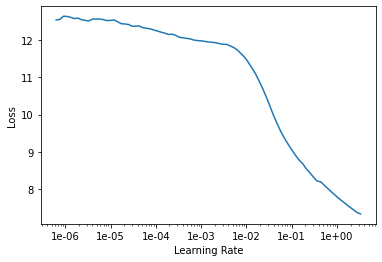

In [ ]:
learn.recorder.plot() #the plot doesn't go up again

In [ ]:
learn.fit_one_cycle(5, 1e-3, wd=0.2) #train : valid loss goes up again at 3rd epoch, goes better at 4th and 5th epoch

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.023755,0.026436,0.153963,02:41
1,0.020178,0.017409,0.130466,02:46
2,0.015324,0.031384,0.126991,02:45
3,0.014982,0.013950,0.110049,02:46
4,0.010677,0.011586,0.103154,02:45


In [ ]:
learn.save('1') #save those weights

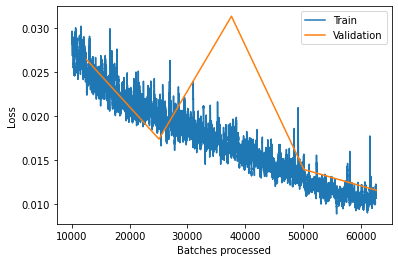

In [ ]:
learn.recorder.plot_losses(skip_start=10000) #we can see when the validation loss went up

In [ ]:
learn.load('1'); #let's load the weights

In [ ]:
learn.fit_one_cycle(5, 3e-4) #train again

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.012302,0.015650,0.131699,02:45
1,0.012798,0.014679,0.110747,02:44
2,0.018088,0.013645,0.116345,02:45
3,0.009762,0.022647,0.108016,02:46
4,0.009746,0.011699,0.105894,02:48


In [ ]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.011440,0.018209,0.113157,02:43
1,0.011363,0.028260,0.123776,02:43
2,0.009927,0.018688,0.117770,02:44
3,0.009487,0.019457,0.110424,02:43
4,0.007978,0.040025,0.125792,02:44


(10th place in the competition was 0.108)

In [ ]:
test_preds=learn.get_preds(DatasetType.Test)
test_df["Sales"]=np.exp(test_preds[0].data).numpy().T[0]
test_df[["Id","Sales"]]=test_df[["Id","Sales"]].astype("int")
test_df[["Id","Sales"]].to_csv("rossmann_submission.csv",index=False)